# Linear Programming Implementation in Python

*These notes are based on a tutorial from [RealPython](https://realpython.com/linear-programming-python/).*

Two packages will be used:
1. SciPy: general-purpose scientific computing package
1. PuLP: linear programming API

## Using SciPy

To define and solve linear optimisation problems using `scipy`, `scipy.optimize.linprog()` will be used.

In [68]:
from scipy.optimize import linprog


### Example 1

Returning to the first simple example in the `linear_prog_theory` notebook:

Find the independent **decision variables** $x$ and $y$ which maximise the objective function $z$:
$$
z = x + 2y
$$

Subject to the **inequality constraints**:
$$
2x + y \leq 20\\
-4x + 5y \leq 10\\
-x + 2y \geq -2\\
-x + 5y = 15\\
x \geq 0\\
y \geq 0
$$

`linprog()` only accepts minimisation problems and also doesn't accept inequality constraints with the $\geq$ sign. To work around this, instead of maximising the objective function, its negative can be minimised instead. $\geq$ equations can be multiplied by $-1$ to be obtained in their $\leq$ form. This results in:

Find the independent **decision variables** $x$ and $y$ which minimise the objective function $z$:
$$
-z = -x - 2y
$$

Subject to the **inequality constraints**:
$$
2x + y \leq 20\\
-4x + 5y \leq 10\\
x - 2y \leq 2\\
-x + 5y = 15\\
x \geq 0\\
y \geq 0
$$

This re-expressed system is equivalent to the original and will have the same solution. Now that the problem is formulated for `linprog()`, it can be implemented:

```python

In [69]:
# Objective function coefficients for x, y
obj = [-1, -2]

# Inequality constraint coefficients x, y for LHS of inequalities 1, 2 and 3
lhs_ineq = [[2, 1], [-4, 5], [1, -2]]

# Inequality constraint constants for RHS of inequalities 1, 2 and 3
rhs_ineq = [20, 10, 2]

# Equality coefficients for x and y, LHS
lhs_eq = [[-1, 5]]

# Equality constants, RHS
rhs_eq = [15]


These can be expressed as lists, tuples or numpy arrays. Each row represents one constraint, and hence the order of the rows for the LHS and RHS of the constraints must be the same. Similarly, each column represents a decision variable, and therefore the order of the coefficients in the objective function and LHS of the constraints must match.

Next, the bounds for each decision variable need to be defined (in the same order as the coefficients):

In [70]:
# Upper and lower bounds of x, y
bnd = [(0, float("inf")), (0, float("inf"))]


Then `linprog()` can be run to solve and optimise the problem:

In [71]:
opt = linprog(
    c=obj,  # coefficients from objective function
    A_ub=lhs_ineq,
    b_ub=rhs_ineq,
    A_eq=lhs_eq,
    b_eq=rhs_eq,
    bounds=bnd,
    method="revised simplex",
)

opt  # Returned optimisation object


     con: array([1.77635684e-15])
     fun: -16.818181818181817
 message: 'Optimization terminated successfully.'
     nit: 3
   slack: array([ 0.        , 18.18181818,  3.36363636])
  status: 0
 success: True
       x: array([7.72727273, 4.54545455])

- `con`: equality constraints residuals
- `fun`: objective function value at optimum (if found)
- `message`: status of the solution
- `nit`: number of iterations
- `slack`: values of the slack variables; the differences between the values on the left and right sides of the constraints
- `status`: status of solution; 0 when optimal solution is found
- `success`: Boolean indicating when optimal solution has been found
- `x`: numpy array holding optimal values of decision variables

In [72]:
# Solution info:
print(f"Minimum value of the objective function: {opt.fun}")
print(f"At x = {opt.x[0]} and y = {opt.x[1]}")


Minimum value of the objective function: -16.818181818181817
At x = 7.727272727272727 and y = 4.545454545454545



The solution (optimal values of $x$ and $y$ variables) can then be plotted:

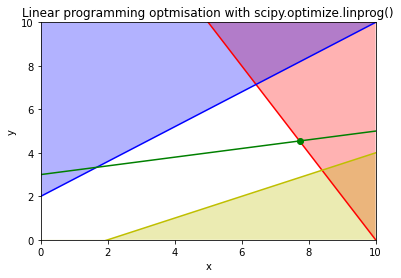

In [73]:
import numpy as np
import matplotlib.pyplot as plt


def plot_example_1():
    x = np.linspace(0, 10)

    constr_a = 20 - 2 * x
    constr_b = (10 + 4 * x) / 5
    constr_c = (-2 + x) / 2

    fig, ax = plt.subplots()
    ax.set_title("Linear programming optmisation with scipy.optimize.linprog()")
    ax.set_ylabel("y")
    ax.set_xlabel("x")
    ax.set_xlim(xmin=x[0], xmax=x[-1])
    ax.set_ylim(0, 10)
    ax.plot(x, constr_a, "r")
    ax.fill_between(x, constr_a, max(constr_a), facecolor="r", alpha=0.3)
    ax.plot(x, constr_b, "b")
    ax.fill_between(x, constr_b, max(constr_b), facecolor="b", alpha=0.3)
    ax.plot(x, constr_c, "y")
    ax.fill_between(x, constr_c, 0, facecolor="y", alpha=0.3)

    return fig, ax, x


fig, ax, x = plot_example_1()
constr_d = 3 + (x / 5)
ax.plot(x, constr_d, "g")

# Add solution with green point
ax.plot(opt.x[0], opt.x[1], "go")


The optimal solutions to linear programming problems lie at the vertices of feasible regions. In this case, the feasible region is defined as the section of the green line between the blue and red lines. The optimal solution is the intersection of the green and red lines, represented by the green circle.

Dropping the equality constraints `A_eq` and `b_eq` from the `linprog()` call results in:

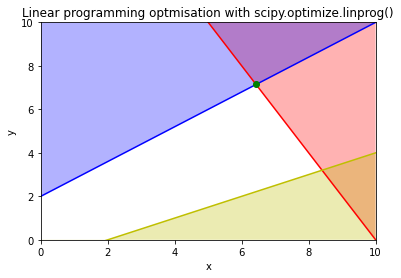

In [74]:
opt = linprog(
    c=obj,
    A_ub=lhs_ineq,
    b_ub=rhs_ineq,
    bounds=bnd,
    method="revised simplex",
)

fig, ax, x = plot_example_1()

# Add solution with green point
ax.plot(opt.x[0], opt.x[1], "go")


The optimal solution (green point) is now at the vertex of the white feasible region defined by the blue and red constraints intersect. Other vertices, such as the red-yellow intersection, have a higher value for the objective function, and are therefore not the optimal solution.

## Example 2

SciPy can be used to solve the slightly more involved resource allocation problem defined in the previous theory notebook.

\begin{equation}
z = 20x_1 + 12x_2 + 40x_3 + 25x_4 \tag{profit}
\end{equation}
\begin{equation}
x_1 + x_2 + x_3 + x_4 <= 50 \tag{manpower}
\end{equation}
\begin{equation}
3x_1 + 2x_2 + x_3 <= 100 \tag{material A}
\end{equation}
\begin{equation}
x_2 + 2x_3 + 3x_4 <= 90 \tag{material B}
\end{equation}
\begin{equation*}
x_1, x_2, x_3, x_4 >= 0
\end{equation*}

In [75]:
obj = [-20, -12, -40, -25]
lhs_ineq = [[1, 1, 1, 1], [3, 2, 1, 0], [0, 1, 2, 3]]
rhs_ineq = [50, 100, 90]
opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq, method="revised simplex")
opt


     con: array([], dtype=float64)
     fun: -1900.0
 message: 'Optimization terminated successfully.'
     nit: 2
   slack: array([ 0., 40.,  0.])
  status: 0
 success: True
       x: array([ 5.,  0., 45.,  0.])

The optimal feasible solution is found with a maximum profit of `1900` at $x_1 = 5$ and $x_3 = 45$. It's not profitable to produce the second and fourth products. Other conclusions are:

1. The third product brings the largest profit per unit (40), so it is produced the most
1. The first slack value is 0, which means the LHS and RHS of the first constraint (manpower) are the same. The factory produces 50 units per day, which is full capacity
1. The second slack value is 40, meaning that the factory consumes 60 units of material A out of a possible 100. Product 1 consumes 15 units of material A in total, and product 3 consumes 45
1. The third slace is 0, meaning that all available 90 units of material B are consumed. It is all used by the third product. The second and fourth product aren't produced at all as there is no material B left over.

### Limitations of SciPy

Linear programming with SciPy has some limitations:
- SciPy can't run other external solvers
- Can't use integer decision variables
- No classes for help with model building; manual array and matrix entry required. This can be confusing and error-prone in more complex problems
- Maximisation problems always need to be converted to minimisation ones
- Constraints must always be formulated used less-than-or-equal-to signs

For more complex problems, PuLP is recommended.

## PuLP

PuLP has a more convenient API for linear programming that doesn't require vectors and matricies. 

### Example 1

Returning to the first example:

Find the independent **decision variables** $x$ and $y$ which maximise the objective function $z$:
$$
z = x + 2y
$$

Subject to the **inequality constraints**:
$$
2x + y \leq 20\\
-4x + 5y \leq 10\\
-x + 2y \geq -2\\
-x + 5y = 15\\
x \geq 0\\
y \geq 0
$$

Now initialise `LpProblem` to represent the model:

In [76]:
import pulp as pl

# Create model
model = pl.LpProblem(name="small_problem", sense=pl.const.LpMaximize)

# Initialise decision variables
x = pl.LpVariable(name="x", lowBound=0)
y = pl.LpVariable(name="y", lowBound=0)


The instances of `LpVariable` can then be used to define other PuLP objects, such as linear expressions and constraints:

In [77]:
expression = 2 * x + 4 * y
print(type(expression))
constraint = 2 * x + 4 * y >= 8
print(type(constraint))


<class 'pulp.pulp.LpAffineExpression'>
<class 'pulp.pulp.LpConstraint'>


PuLP can detect the difference between an expression and a constraint by the presence of a comparison operator (`==`, `<=` or `>=`). It's therefore possible to define the objective function and constraints and add them to the model without creating lists or matrices.

In [78]:
# Add the constraints to the model
model += (2 * x + y <= 20, "red_constraint")
model += (4 * x - 5 * y >= -10, "blue_constraint")
model += (-x + 2 * y >= -2, "yellow_constraint")
model += (-x + 5 * y == 15, "green_constraint")


`LpProblem` allows you to add constraints to the model by speicfying them as tuples, with the first argument as a `LpConstraint` instance and the second as a name. Now add the objective function:

In [79]:
# Add objective function to model
model += x + 2 * y
model


small_problem:
MAXIMIZE
1*x + 2*y + 0
SUBJECT TO
red_constraint: 2 x + y <= 20

blue_constraint: 4 x - 5 y >= -10

yellow_constraint: - x + 2 y >= -2

green_constraint: - x + 5 y = 15

VARIABLES
x Continuous
y Continuous

In [80]:
# Solve the problem
status = model.solve()


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/jon/code/linearprog/.venv/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/5ad8983e1a4341469d2b9cf0dd1f32fb-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/5ad8983e1a4341469d2b9cf0dd1f32fb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 20 RHS
At line 25 BOUNDS
At line 26 ENDATA
Problem MODEL has 4 rows, 2 columns and 8 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-4) rows, 0 (-2) columns and 0 (-8) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 16.818182
After Postsolve, objective 16.818182, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 16.81818182 - 0 iterations time 0.002, Presolve 0.00
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wa

The optimisation results can be accessed as attributes of `model`:

In [81]:
print(f"status: {model.status}, {pl.LpStatus[model.status]}")
print(f"objective value: {model.objective.value()}")
print("Optimal values of decision variables:")
for var in model.variables():
    print(f"{var.name}: {var.value()}")

print("Slack values of constraints:")
for name, constraint in model.constraints.items():
    print(f"{name}: {constraint.value()}")


status: 1, Optimal
objective value: 16.8181817
Optimal values of decision variables:
x: 7.7272727
y: 4.5454545
Slack values of constraints:
red_constraint: -9.99999993922529e-08
blue_constraint: 18.181818300000003
yellow_constraint: 3.3636362999999996
green_constraint: -2.0000000233721948e-07


These results are similar to the ones obtained using SciPy.

### Mixed-integer problems with PuLP

Mixed-integer linear programming problems can be solved by PuLP, using `LpVariable` with `cat="Integer"` or `cat="Binary"`.

In [82]:
# Create the model
model = pl.LpProblem(name="small-problem", sense=pl.const.LpMaximize)

# Initialise the decision variables: x is integer, y is continuous
x = pl.LpVariable(name="x", lowBound=0, cat="Integer")
y = pl.LpVariable(name="y", lowBound=0)

# Add the constraints to the model
model += (2 * x + y <= 20, "red_constraint")
model += (4 * x - 5 * y >= -10, "blue_constraint")
model += (-x + 2 * y >= -2, "yellow_constraint")
model += (-x + 5 * y == 15, "green_constraint")

# Add the objective function to the model
model += pl.lpSum([x, 2 * y])

# Solve the problem
status = model.solve()


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/jon/code/linearprog/.venv/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/df04c127f227467f9040c52d5997d3db-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/df04c127f227467f9040c52d5997d3db-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 22 RHS
At line 27 BOUNDS
At line 29 ENDATA
Problem MODEL has 4 rows, 2 columns and 8 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 16.8182 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from -15.8 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Gomory was tried 0 ti

In [83]:
def print_results(model):
    print(f"status: {model.status}, {pl.LpStatus[model.status]}")
    print(f"objective value: {model.objective.value()}")
    print("Optimal values of decision variables:")
    for var in model.variables():
        print(f"{var.name}: {var.value()}")

    print("Slack values of constraints:")
    for name, constraint in model.constraints.items():
        print(f"{name}: {constraint.value()}")

print_results(model)


status: 1, Optimal
objective value: 15.8
Optimal values of decision variables:
x: 7.0
y: 4.4
Slack values of constraints:
red_constraint: -1.5999999999999996
blue_constraint: 16.0
yellow_constraint: 3.8000000000000007
green_constraint: 0.0


Now $x$ is an integer, the solution changes:

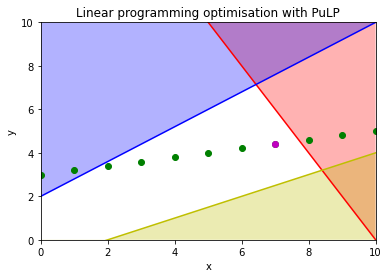

In [84]:
fig, ax, x = plot_example_1()
ax.set_title("Linear programming optimisation with PuLP")

# Plot green integer constraint
x_int = np.arange(0, 11, 1)
constr_d_int = 3 + (x_int / 5)
ax.plot(x_int, constr_d_int, "go")

# Highlight optimal mixed-integer solution
vars = model.variables()
ax.plot(vars[0].value(), vars[1].value(), "mo")


The magenta point is the optimal feasible solution; the largest values of both $x$ and $y$, giving the largest possible value of the objective function.

### Example 2

Now PuLP can be used to solve the previous resource allocation problem again.

In [92]:
# Define model
model = pl.LpProblem(name="resource_allocation", sense=pl.const.LpMaximize)

# Define decision variables
x = {i: pl.LpVariable(name=f"x{i}", lowBound=0) for i in range(1,5)}

# Add constraints
model += (pl.lpSum(x.values()) <= 50, "manpower")
model += (3*x[1]+2*x[2]+x[3] <= 100, "material_a")
model+=(x[2]+2*x[3]+3*x[4] <=90, "material_b")

# Define objective function
model += 20*x[1]+12*x[2]+40*x[3]+25*x[4]

# Solve optimisation problem
status = model.solve()


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/jon/code/linearprog/.venv/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/533cffe942bd487a89649000b8c5bf19-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/533cffe942bd487a89649000b8c5bf19-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 8 COLUMNS
At line 23 RHS
At line 27 BOUNDS
At line 28 ENDATA
Problem MODEL has 3 rows, 4 columns and 10 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 3 (0) rows, 4 (0) columns and 10 (0) elements
0  Obj -0 Dual inf 97 (4)
0  Obj -0 Dual inf 97 (4)
2  Obj 1900
Optimal - objective value 1900
Optimal objective 1900 - 2 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00



In [93]:
# Print results
print_results(model)

status: 1, Optimal
objective value: 1900.0
Optimal values of decision variables:
x1: 5.0
x2: 0.0
x3: 45.0
x4: 0.0
Slack values of constraints:
manpower: 0.0
material_a: -40.0
material_b: 0.0


This solution is the same as achieved with SciPy. The most profitable solution produces 5 of product 1 and 45 of product 3 per day.

Suppose the factory can't produce products 1 and 3 in parallel due to a machinery issue. What's the optimal solution now?

If $x_1$ is positive, then $x_3$ must be 0 and vice versa. This can be represented using binary decision variables, $y_1$ and $y_3$, which indicate whether $x_1$ and $x_3$ are produced.

In [95]:
model = pl.LpProblem(name="resource_allocation", sense=pl.LpMaximize)

# Define the decision variables
x = {i: pl.LpVariable(name=f"x{i}", lowBound=0) for i in range(1, 5)}
y = {i: pl.LpVariable(name=f"y{i}", cat="Binary") for i in (1, 3)}

# Add constraints
model += (pl.lpSum(x.values()) <= 50, "manpower")
model += (3 * x[1] + 2 * x[2] + x[3] <= 100, "material_a")
model += (x[2] + 2 * x[3] + 3 * x[4] <= 90, "material_b")

# Arbitrarily large constant; impossible to produce > 100 units per day
M = 100
# if y[1] == 0, x[1] == 0
model += (x[1] <= y[1] * M, "x1_constraint")
# if y[3] == 0, x[3] == 0
model += (x[3] <= y[3] * M, "x3_constraint")
# y[1] == 0 and/or y[3] == 0, therefore x[1] == 0 and/or x[3] == 0 too
model += (y[1] + y[3] <= 1, "y_constraint")

# Set objective
model += 20 * x[1] + 12 * x[2] + 40 * x[3] + 25 * x[4]

# Solve the optimisation problem
status = model.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/jon/code/linearprog/.venv/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/96378f12ef12462a8b9464867de9a582-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/96378f12ef12462a8b9464867de9a582-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 36 RHS
At line 43 BOUNDS
At line 46 ENDATA
Problem MODEL has 6 rows, 6 columns and 16 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1900 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0004I processed model has 6 rows, 6 columns (2 integer (2 of which binary)) and 16 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 4.44089e-16
Cbc0038I Solution found of -1800
Cbc0038I Relaxing continuous gives -1800
Cbc0038I Before mini branch 

In [96]:
print_results(model)

status: 1, Optimal
objective value: 1800.0
Optimal values of decision variables:
x1: 0.0
x2: 0.0
x3: 45.0
x4: 0.0
y1: 0.0
y3: 1.0
Slack values of constraints:
manpower: -5.0
material_a: -55.0
material_b: 0.0
x1_constraint: 0.0
x3_constraint: -55.0
y_constraint: 0.0


The optimal solution is to not make the first product and only make the third one.

## Conclusion

This shows both the basic theory of linear programming optimisation problems and their implementation in Python. A simple case and a more complex, real-world problem have been explored. Additionally, mixed-integer and binary constraints have been applied. The SciPy and PuLP packages have been used to solve the optimisation problem in each case.